In [1]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [4]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [5]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [6]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211119/', 
                    Selection='*DCR*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D0.Files))
for File in D0.Files[:200]:
    D0.ImportDataFromHDF5(File, D0.Ch)

226


In [7]:
def gauss(x,mu=0,sigma=0.5):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

In [8]:
time = D0.Ch[0].Time
desire_x = np.arange(-500,500,time[1]-time[0])
desire_y = gauss(desire_x, mu=0,sigma=1)
desire_y2 = gauss(desire_x, mu=0,sigma=0.1)
resp_x = np.arange(0,1000,time[1]-time[0])
resp_y = D0.func(resp_x, 0, 1, 1.83, 46.93, 0)

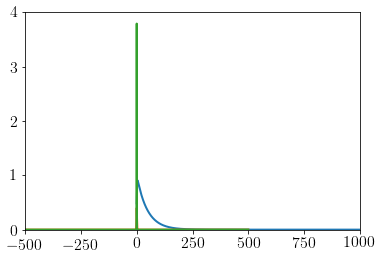

In [9]:
plt.plot(resp_x, resp_y,label='Response')
plt.plot(desire_x, desire_y,label='Desired')
plt.plot(desire_x, desire_y2,label='Desired2')

In [10]:
resp_f = np.fft.fft(resp_y)

desire_f = np.fft.fft(desire_y)
filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

desire_f2 = np.fft.fft(desire_y2)
filter_f2 = desire_f2/resp_f
filter_y2 = np.real(np.fft.ifft(filter_f2))

In [11]:
import random
times = [random.randint(0,1000) for x in range(50)]
ampl = [random.randint(0,100)/100.0 for x in range(50)]
f_sing = [D0.func(resp_x, 0, ampl[i], 1.83, 46.93, times[i]) for i in range(len(times))]
    
f_sum = np.sum(f_sing, axis=0)
deconv_y = np.convolve(f_sum,filter_y,'same')
deconv_y2 = np.convolve(f_sum,filter_y2,'same')

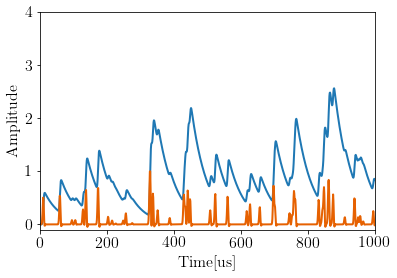

In [12]:
plt.figure()
plt.xlabel('Time[us]')
plt.ylabel('Amplitude')
plt.ylim(-0.1,4)
plt.plot(resp_x, f_sum,label='Response')
# plt.plot(resp_x, deconv_y/np.max(deconv_y),label='Deconvolved')
plt.plot(resp_x, deconv_y2/np.max(deconv_y2),label='Deconvolved')

plt.savefig('deconvolution.pdf')
plt.show()

In [13]:
count = 0
filt = D0.get_filtered_waveform(D0.Ch[0].Time, D0.Ch[0].Amp[0], lowfreq=100, highfreq=100000, type='band', order=3)
for j in range(100):
    if np.max(filt[1000*j:1000*(j+1)])>20:
        count +=1
        deconv = np.convolve(filt[1000*j:1000*(j+1)]*count,filter_y,'same')
        print(np.max(deconv))
        plt.figure()
        plt.plot(time[1000*j:1000*(j+1)], filt[1000*j:1000*(j+1)],label='Response')
        plt.plot(time[1000*j:1000*(j+1)], deconv,label='Deconvolved')
        plt.show()

In [14]:
start = D0.Ch[0].Time[0]
length = D0.Ch[0].Time[-1] - D0.Ch[0].Time[0]
window = 1000
count = int(length/window)
print(start, length,window, count)

-50000.327999999994 100000.65599999999 1000 100


In [38]:
maxval = []
maxtime = []
for i,Amp in enumerate(D0.Ch[0].Amp):
    filt = D0.get_filtered_waveform(D0.Ch[0].Time, Amp, lowfreq=100, highfreq=100000, type='band', order=3)
    for j in range(count-1):
        if np.max(filt[1000*j:1000*(j+1)])>20:
            deconv = np.convolve(filt[1000*j:1000*(j+1)],filter_y,'same')        
            peaks,pdict = find_peaks(deconv, height=5, width=1, distance=10)
            if len(pdict['peak_heights'])>0:
                for i,p in enumerate(pdict['peak_heights']):
                    maxval.append(p)
                    maxtime.append(D0.Ch[0].Time[1000*j:1000*(j+1)][peaks[i]])

[0.052571   0.03271541 0.02768448 0.02216912 0.02446    0.01959516]
[7.45111384 7.48374647 7.39862408 7.46329589 7.72847443]
7.505050943311471
0.11519661979086453
1.3631795828457245


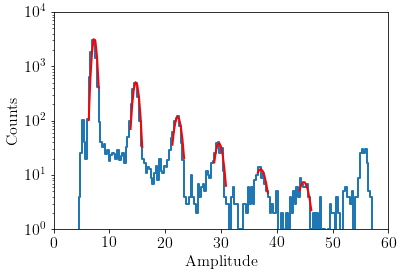

In [39]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

h,hx = np.histogram(maxval, bins=np.arange(0,60,0.3))

pe = np.median(maxval)
pe_fit = []

plt.figure()
for i in range(1,7):
    i = i*0.99
    cut = np.where((hx[:-1]>pe*i-1.5) & (hx[:-1]<pe*i+0.8))
    
    popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
                          p0=[np.max(h[cut]), pe*i,10 ])
    pe_fit.append(popt)
    plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

print(np.abs(np.array(pe_fit)[:,2])/np.array(pe_fit)[:,1] )
print(np.diff(np.array(pe_fit)[:,1]))
print(np.mean(np.diff(np.array(pe_fit)[:,1])))
print(np.std(np.diff(np.array(pe_fit)[:,1])))

newvals = np.array(maxval)/np.mean(np.diff(np.array(pe_fit)[:,1]))
print(np.mean(newvals[newvals<6]))


plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2)
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

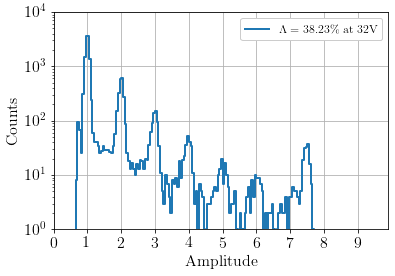

In [61]:
gain = np.diff(np.array(pe_fit)[:,1])
gain = np.insert(gain,0,np.array(pe_fit)[0,1])
ca = (np.mean(newvals[newvals<7]) - 1)*100

h,hx = np.histogram(np.array(maxval)/np.mean(gain), bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.2f}$\% at 32V'.format(ca))
plt.legend(loc='upper right')
plt.savefig('deconvolution_hist_pe.pdf')
plt.show()

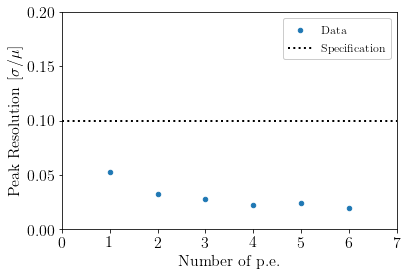

In [41]:
res = np.abs(np.array(pe_fit)[:,2])/np.array(pe_fit)[:,1]

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.scatter(np.arange(1,len(res)+1,1), res, marker='o', s=20, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
plt.show()

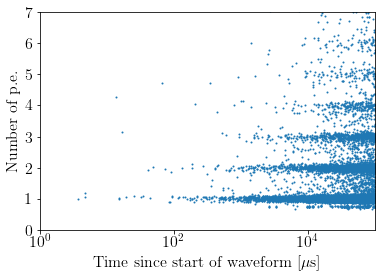

In [58]:
plt.figure()
plt.xlim(1,1e5)
plt.ylim(0,7)
plt.xscale('log')
plt.yticks(np.arange(0,8,1))
plt.xlabel('Time since start of waveform [$\mu$s]')
plt.ylabel('Number of p.e.')
plt.scatter(np.array(maxtime)+50000, maxval/np.mean(gain), s=1)
plt.show()